In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys

from itertools import combinations 
from scipy.stats import boxcox
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.stats.anova import anova_lm

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from classify_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## functions

In [5]:
def calculate_gc(row, col):
    cs = row[col].count("C")
    gs = row[col].count("G")
    gc = (cs+gs)/len(row[col])
    return gc

In [6]:
def calculate_cpg(row, col):
    cpgs = row[col].count("CG")
    cpg = cpgs/len(row[col])
    return cpg

In [7]:
def lrtest(llmin, llmax):
    lr = 2 * (llmax - llmin)
    p = stats.chisqprob(lr, 1) # llmax has 1 dof more than llmin
    return lr, p

## variables

In [8]:
motif_dir = "../../../data/04__mapped_motifs/elem_fimo_out"
motifs_f = "%s/fimo.txt.gz" % motif_dir

In [9]:
elem_map_f = "../../../data/04__mapped_motifs/fastas/elem_map.txt"

In [10]:
motif_info_dir = "../../../misc/01__motif_info"
motif_map_f = "%s/00__lambert_et_al_files/00__metadata/curated_motif_map.txt" % motif_info_dir
motif_info_f = "%s/00__lambert_et_al_files/00__metadata/motif_info.txt" % motif_info_dir

In [11]:
sig_motifs_f = "../../../data/04__mapped_motifs/sig_motifs.txt"

In [12]:
tss_map_f = "../../../data/01__design/01__mpra_list/mpra_tss.with_ids.RECLASSIFIED.txt"

In [13]:
index_f = "../../../data/01__design/02__index/TWIST_pool4_v8_final.with_element_id.txt.gz"

In [14]:
data_f = "../../../data/02__mpra/03__results/all_processed_results.txt"

## 1. import data

In [15]:
index = pd.read_table(index_f, sep="\t")
index_elem = index[["element", "tile_type", "element_id", "name", "tile_number", "chrom", "strand", "actual_start", 
                    "actual_end", "dupe_info"]]
index_elem = index_elem.drop_duplicates()

In [16]:
tss_map = pd.read_table(tss_map_f, sep="\t")
tss_map.head()

,hg19_id,mm9_id,cage_id_hg19,cage_id_mm9,name_peak_hg19,name_peak_mm9,biotype_hg19,biotype_mm9,minimal_biotype_hg19,minimal_biotype_mm9,...,end_tss_mm9,strand_tss_mm9,avg_exp_hg19,avg_exp_mm9,stem_exp_hg19,stem_exp_mm9,max_cage_hg19,max_cage_mm9,orig_species,har
0,h.0,m.0,"chr1:2984976..2984989,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,154011664,+,0.1,0.43,0.027777800000000002,0.0175,367.0,2286.0,human,False
1,h.1,m.0,"chr1:2984997..2985037,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,154011664,+,0.29,0.43,0.0311111,0.0175,367.0,2286.0,human,False
2,h.2,m.1,"chr1:2985420..2985438,-","chr4:154011250..154011257,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,154011253,+,2.54,0.85,0.07111110000000001,0.0,6966.0,1361.0,human,False
3,h.3,m.2,"chr1:8086546..8086571,+","chr4:150229039..150229050,-",ENSG00000238290.1,ENSMUSG00000078492.3,divergent,antisense,lncRNA,lncRNA,...,150229045,-,0.3,0.14,0.10444400000000001,0.0,960.0,123.0,human,False
4,h.4,m.3,"chr1:26498321..26498327,-","chr4:133799669..133799683,+",ENSG00000236782.1,ENSMUSG00000086322.7,antisense,protein_coding,other,mRNA,...,133799678,+,0.19,0.25,0.03,0.0,753.0,770.0,human,False


In [17]:
motifs = pd.read_table(motifs_f, sep="\t")
motifs.head()

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence
0,ZNF212,elem_7205,1,30,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA
1,ZNF212,elem_7205,3,32,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA
2,ZNF212,elem_10288,5,34,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA
3,ZNF212,elem_7205,5,34,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA
4,ZNF212,elem_10288,7,36,+,55.8485,7.500000e-19,1.490000e-14,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGA


In [18]:
elem_map = pd.read_table(elem_map_f, sep="\t")
elem_map.head()

,elem_key,elem
0,elem_1,AAAAAAAAAAAAAAAAACCCTGCAGAGAGCCTGCAAAGTCACTGCC...
1,elem_2,AAAAAAAAAAAAAAAGAAAAGAAAAGAAAAAAAAGAAAGGATTGAG...
2,elem_3,AAAAAAAAAAAAGAGGAGAAATAGATTGTTACCTTATATTATTTAA...
3,elem_4,AAAAAAAAAACCGGCAAAATGTCCTTTTCCTTGTTTTGAAAAGACT...
4,elem_5,AAAAAAAAAGGCCACGCTCAAAACCCCAGACTAGTTTTCCTCACCA...


In [19]:
motif_map = pd.read_table(motif_map_f, sep="\t")
motif_map.head()

,index,gene_id,gene_name
0,HKR1,ENSG00000181666,HKR1
1,M00117_1,ENSG00000137203,TFAP2A
2,M00118_1,ENSG00000137203,TFAP2A
3,M00119_1,ENSG00000137203,TFAP2A
4,M00120_1,ENSG00000137203,TFAP2A


In [20]:
motif_info = pd.read_table(motif_info_f, sep="\t")
motif_info.head()

,Ensembl ID,HGNC symbol,Motif evidence,Motif ID,Motif type,Motif source,CIS-BP ID,Best Motif(s)? (Figure 2A)
0,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_HT-SELEX,HT-SELEX,Yin2017,M08490_1.94d,True
1,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M08491_1.94d,NaN
2,ENSG00000267281,AC023509.3,"Inferred - Atf7 (98% AA Identity, Mus musculus)",3T3L1-Atf7_GSE56872,Misc,HOMER,M06975_1.94d,NaN
3,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_HT-SELEX,HT-SELEX,Yin2017,M09315_1.94d,True
4,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M09316_1.94d,NaN


In [21]:
sig_motifs = pd.read_table(sig_motifs_f)
sig_motifs = sig_motifs[sig_motifs["padj"] < 0.05]
print(len(sig_motifs))
sig_motifs.head()

487


,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr
0,HKR1,6.281798,0.012198,0.000384,0.048118,0.037451,HKR1,HKR1,activating,NaN,NaN,NaN,3.0
1,M00144_1,10.738762,0.001049,0.000657,-0.275327,0.004341,M00144_1,ARID5A,repressing,0.0,NaN,NaN,NaN
2,M00224_1,8.999747,0.002700,0.000550,-0.228712,0.010206,M00224_1,TWIST2,repressing,0.0,NaN,NaN,NaN
3,M00226_1,6.933266,0.008461,0.000424,0.133341,0.027823,M00226_1,ARNT,activating,NaN,NaN,NaN,NaN
4,M00242_1,18.650533,0.000016,0.001140,-0.321524,0.000096,M00242_1,SCX,repressing,NaN,1.0,NaN,NaN


In [22]:
data = pd.read_table(data_f)
data.head()

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.333118,-0.035380,0.988785,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.536610,-0.387857,0.921562,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.260673,-0.192854,0.959265,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.439975,-0.723633,0.197618,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.267503,-0.511763,0.453490,no cis/trans int. effect,no cis/trans int. effect


## 2. filter to significant motifs only (found via model)

In [23]:
mapped_sig_motifs = motifs[motifs["#pattern name"].isin(sig_motifs["index"])]
len(mapped_sig_motifs)

853831

In [24]:
uniq_motifs = list(mapped_sig_motifs["#pattern name"].unique())
print(len(uniq_motifs))

464


## 3. join motifs w/ element metadata

In [25]:
motifs_merged = mapped_sig_motifs.merge(elem_map, left_on="sequence name", right_on="elem_key")
motifs_merged.head()

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence,elem_key,elem
0,ZNF785,elem_1730,22,50,+,41.2245,2.570000e-16,1.100000e-11,ACACACACACACACACGCACACACACACA,elem_1730,AGCACCCACACACACACACACACACACACACACACACGCACACACA...
1,ZNF785,elem_1730,34,62,+,41.1224,3.060000e-16,1.100000e-11,ACACGCACACACACACACACACACACACA,elem_1730,AGCACCCACACACACACACACACACACACACACACACGCACACACA...
2,ZNF785,elem_1730,8,36,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,AGCACCCACACACACACACACACACACACACACACACGCACACACA...
3,ZNF785,elem_1730,40,68,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,AGCACCCACACACACACACACACACACACACACACACGCACACACA...
4,ZNF785,elem_1730,42,70,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,AGCACCCACACACACACACACACACACACACACACACGCACACACA...


In [26]:
motifs_merged = motifs_merged.merge(index_elem, left_on="elem", right_on="element")
motifs_merged.head()

,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,element,tile_type,element_id,name,tile_number,chrom,strand_y,actual_start,actual_end,dupe_info
0,ZNF785,elem_1730,22,50,+,41.2245,2.570000e-16,1.100000e-11,ACACACACACACACACGCACACACACACA,elem_1730,...,AGCACCCACACACACACACACACACACACACACACACGCACACACA...,WILDTYPE,MOUSE_EVO_TSS__m.2316__tile2:47577997-47578141...,MOUSE_EVO_TSS__m.2316__tile2,1.0,chr14,+,47577997,47578141,9349.1.0.0
1,ZNF785,elem_1730,34,62,+,41.1224,3.060000e-16,1.100000e-11,ACACGCACACACACACACACACACACACA,elem_1730,...,AGCACCCACACACACACACACACACACACACACACACGCACACACA...,WILDTYPE,MOUSE_EVO_TSS__m.2316__tile2:47577997-47578141...,MOUSE_EVO_TSS__m.2316__tile2,1.0,chr14,+,47577997,47578141,9349.1.0.0
2,ZNF785,elem_1730,8,36,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,...,AGCACCCACACACACACACACACACACACACACACACGCACACACA...,WILDTYPE,MOUSE_EVO_TSS__m.2316__tile2:47577997-47578141...,MOUSE_EVO_TSS__m.2316__tile2,1.0,chr14,+,47577997,47578141,9349.1.0.0
3,ZNF785,elem_1730,40,68,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,...,AGCACCCACACACACACACACACACACACACACACACGCACACACA...,WILDTYPE,MOUSE_EVO_TSS__m.2316__tile2:47577997-47578141...,MOUSE_EVO_TSS__m.2316__tile2,1.0,chr14,+,47577997,47578141,9349.1.0.0
4,ZNF785,elem_1730,42,70,+,40.5204,1.250000e-15,1.100000e-11,ACACACACACACACACACACACACACACA,elem_1730,...,AGCACCCACACACACACACACACACACACACACACACGCACACACA...,WILDTYPE,MOUSE_EVO_TSS__m.2316__tile2:47577997-47578141...,MOUSE_EVO_TSS__m.2316__tile2,1.0,chr14,+,47577997,47578141,9349.1.0.0


In [27]:
motifs_merged["tss_id"] = motifs_merged["name"].str.split("__", expand=True)[1]
motifs_merged["species"] = motifs_merged["name"].str.split("_", expand=True)[0]
motifs_merged["tss_tile_num"] = motifs_merged["name"].str.split("__", expand=True)[2]
motifs_merged.sample(5)

,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,name,tile_number,chrom,strand_y,actual_start,actual_end,dupe_info,tss_id,species,tss_tile_num
744066,M10335_1,elem_4192,2,19,-,13.90820,0.000006,0.0221,TTGGGATGGAGGAGGTGG,elem_4192,...,MOUSE_EVO_TSS__m.2859__tile2,1.0,chr7,-,63217903,63218047,13172.1.0.0,m.2859,MOUSE,tile2
616569,M09391_1,elem_4369,104,116,-,9.33945,0.000076,0.0323,CAAGCCCCCCACC,elem_4369,...,MOUSE_EVO_TSS__m.2426__tile2,1.0,chr2,-,17977693,17977837,10700.1.0.0,m.2426,MOUSE,tile2
337312,M10432_1,elem_6226,100,107,-,15.00000,0.000007,0.0141,GGGCGGGG,elem_6226,...,MOUSE_EVO_TSS__m.914__tile1,1.0,chr9,-,100446497,100446641,14026.1.0.0,m.914,MOUSE,tile1
266821,M05963_1,elem_7235,75,86,+,11.88780,0.000014,0.0473,TGCTCATGCGCC,elem_7235,...,MOUSE_EVO_TSS__m.847__tile1,1.0,chr11,-,100406868,100407012,8560.1.0.0,m.847,MOUSE,tile1
244704,M03040_1,elem_1905,23,37,-,12.92860,0.000022,0.1510,ATGATTGGTCGGCTC,elem_1905,...,MOUSE_EVO_TSS__m.2095__tile1,1.0,chr17,+,3102462,3102606,9940.1.0.0,m.2095,MOUSE,tile1


In [28]:
human_df = motifs_merged[(motifs_merged["species"] == "HUMAN") | (motifs_merged["name"] == "random_sequence")]
mouse_df = motifs_merged[(motifs_merged["species"] == "MOUSE") | (motifs_merged["name"] == "random_sequence")]

human_df = human_df.merge(tss_map[["hg19_id", "biotype_hg19", 
                                   "minimal_biotype_hg19", "stem_exp_hg19", "orig_species"]], 
                          left_on="tss_id", right_on="hg19_id", how="left")
mouse_df = mouse_df.merge(tss_map[["mm9_id", "biotype_mm9", 
                                   "minimal_biotype_mm9", "stem_exp_mm9", "orig_species"]], 
                          left_on="tss_id", right_on="mm9_id", how="left")

print(len(human_df))
print(len(mouse_df))
mouse_df.sample(5)

464572
460582


,#pattern name,sequence name,start,stop,strand_x,score,p-value,q-value,matched sequence,elem_key,...,actual_end,dupe_info,tss_id,species,tss_tile_num,mm9_id,biotype_mm9,minimal_biotype_mm9,stem_exp_mm9,orig_species
457339,M08749_1,elem_9677,119,128,+,12.20410,0.000031,0.4020,TCCAGGTGTC,elem_9677,...,0,none,None,random,None,NaN,NaN,NaN,NaN,NaN
280117,M10051_1,elem_4823,34,52,+,9.60000,0.000075,0.1360,GCGTCCCTCTCCCTCCCCT,elem_4823,...,107832872,12332.1.0.0,m.2642,MOUSE,tile2,m.2642,divergent,other,0.05125,mouse
158728,ZNF880,elem_9314,32,58,-,9.52727,0.000054,0.0117,CTGTCCGCCTCCTTCTTCCCCCGCCTG,elem_9314,...,73224579,13622.1.0.0,m.2390,MOUSE,tile2,m.2390,antisense,other,0.11375,mouse
48281,ZNF202,elem_8386,66,73,-,6.10204,0.000066,0.0725,CCGCATCC,elem_8386,...,25918457,13030.1.0.0,m.3483,MOUSE,tile2,m.3483,enhancer,NaN,0.153347,human
103185,M06854_1,elem_6396,55,66,+,12.07140,0.000030,0.0383,GAGGGAGGGGGA,elem_6396,...,49928792,13577.1.0.0,m.183,MOUSE,tile2,m.183,divergent,other,0.0,human


In [29]:
human_df = human_df.drop_duplicates()
mouse_df = mouse_df.drop_duplicates()

print(len(human_df))
print(len(mouse_df))

457658
429119


## 4. merge cis data w/ element data for model

In [30]:
index_elem = index_elem[index_elem["name"].str.contains("EVO")]
index_elem.head()

,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info
58627,CTTCGTGCCTGGACACCGTCCCCCAGCCTGGCTCCAGCTGCCCCGG...,WILDTYPE,"HUMAN_EVO_TSS__h.1539__tile2:1355317-1355461,+...",HUMAN_EVO_TSS__h.1539__tile2,1.0,chr1,+,1355317,1355461,11.1.0.0
58640,CTGGGAGCGGCCTAGGGCGGCCGCCAGACCCAGCGCTGTGGCCCCC...,WILDTYPE,"HUMAN_EVO_TSS__h.1539__tile1:1355431-1355575,+...",HUMAN_EVO_TSS__h.1539__tile1,1.0,chr1,+,1355431,1355575,12.1.0.0
58653,GGGCTGACGCTGCCTTGGGTTCGCCTACGTCCCTCGGGAATTTTGT...,WILDTYPE,"HUMAN_EVO_TSS__h.3020__tile2:1447313-1447457,+...",HUMAN_EVO_TSS__h.3020__tile2,1.0,chr1,+,1447313,1447457,13.1.0.0
58666,CCACACACACCCCTTCCTCCCGGCGATAGAAGCGCGTAAGGGACAC...,WILDTYPE,"HUMAN_EVO_TSS__h.2871__tile1:1447388-1447532,-...",HUMAN_EVO_TSS__h.2871__tile1,1.0,chr1,-,1447388,1447532,14.1.0.0
58679,AGTCGCGGCGCCGTCGCTATGGCGTCACTGTCCTCGGGGCCAATCC...,WILDTYPE,"HUMAN_EVO_TSS__h.3020__tile1:1447427-1447571,+...",HUMAN_EVO_TSS__h.3020__tile1,1.0,chr1,+,1447427,1447571,15.1.0.0


In [31]:
index_elem["tss_id"] = index_elem["name"].str.split("__", expand=True)[1]
index_elem["tss_tile_num"] = index_elem["name"].str.split("__", expand=True)[2]
index_elem.sample(5)

,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info,tss_id,tss_tile_num
202485,CGTTTGGCGCCCGGTGTGTGGCCTTGCATATCCTTGCAGTGAAAAG...,WILDTYPE,MOUSE_EVO_TSS__m.1969__tile2:11315038-11315182...,MOUSE_EVO_TSS__m.1969__tile2,1.0,chr4,+,11315038,11315182,11691.1.0.0,m.1969,tile2
75319,GGAGGCGGACCCTGCACGCCCGGCGGCTCCGCGCCCCGTGATTGGT...,WILDTYPE,HUMAN_EVO_TSS__h.1627__tile2:71159488-71159632...,HUMAN_EVO_TSS__h.1627__tile2,1.0,chr11,+,71159488,71159632,1346.1.0.0,h.1627,tile2
169972,TAGCAGCATTAATTTCGTTGATTGTGAATATGCAAGCTGTTCCTGC...,WILDTYPE,MOUSE_EVO_TSS__m.2276__tile2:20446472-20446616...,MOUSE_EVO_TSS__m.2276__tile2,1.0,chr13,+,20446472,20446616,9030.1.0.0,m.2276,tile2
187717,GGGGGGGGACACCTCACTTCCGCTTGGTGGTCCGGGACTAGATCTC...,WILDTYPE,"MOUSE_EVO_TSS__m.2795__tile2:7457013-7457157,-...",MOUSE_EVO_TSS__m.2795__tile2,1.0,chr19,-,7457013,7457157,10496.1.0.0,m.2795,tile2
172481,TGGACGAAAGGAAAGAAACAGCCGCGGACCGGCCCCCGGCTGCGCA...,WILDTYPE,"MOUSE_EVO_TSS__m.949__tile1:99086904-99087048,...",MOUSE_EVO_TSS__m.949__tile1,1.0,chr13,-,99086904,99087048,9238.1.0.0,m.949,tile1


In [32]:
index_human = index_elem[index_elem["name"].str.contains("HUMAN")]
index_mouse = index_elem[index_elem["name"].str.contains("MOUSE")]
index_mouse.sample(5)

,element,tile_type,element_id,name,tile_number,chrom,strand,actual_start,actual_end,dupe_info,tss_id,tss_tile_num
198676,TCAGATTTTGTTCATGAGAACCCAGGAAACAAAAATTAAGATTGTT...,WILDTYPE,MOUSE_EVO_TSS__m.3277__tile1:85834106-85834250...,MOUSE_EVO_TSS__m.3277__tile1,1.0,chr3,-,85834106,85834250,11381.1.0.0,m.3277,tile1
232216,TCCATTTATTTTCTTGATATCAGGAAGAATAAGAGTTAAAGAGGGT...,WILDTYPE,MOUSE_EVO_TSS__m.1797__tile1:18739194-18739338...,MOUSE_EVO_TSS__m.1797__tile1,1.0,chrX,-,18739194,18739338,14155.1.0.0,m.1797,tile1
150329,GCATCTCAGAAGAGAAAGGAAGCCACTGCTAATGGCCTGTGACAGC...,WILDTYPE,MOUSE_EVO_TSS__m.2247__tile1:72333486-72333630...,MOUSE_EVO_TSS__m.2247__tile1,1.0,chr1,-,72333486,72333630,7430.1.0.0,m.2247,tile1
159611,AAATTACATTTTTTTTTTTGAACGATGAGGGAACATCTAATCAAAG...,WILDTYPE,MOUSE_EVO_TSS__m.1940__tile1:21903232-21903376...,MOUSE_EVO_TSS__m.1940__tile1,1.0,chr11,+,21903232,21903376,8182.1.0.0,m.1940,tile1
195881,GAATGAGGTGGCTCTGCCCGTGCAGCGCTCTATGGCTGATGTTTCC...,WILDTYPE,MOUSE_EVO_TSS__m.2935__tile2:162948122-1629482...,MOUSE_EVO_TSS__m.2935__tile2,1.0,chr2,+,162948122,162948266,11159.1.0.0,m.2935,tile2


In [33]:
print(len(data))
data_elem = data.merge(index_human[["element", "tss_id", "tss_tile_num"]], left_on=["hg19_id", "tss_tile_num"],
                       right_on=["tss_id", "tss_tile_num"])
data_elem = data_elem.merge(index_mouse[["element", "tss_id", "tss_tile_num"]], left_on=["mm9_id", "tss_tile_num"],
                            right_on=["tss_id", "tss_tile_num"], suffixes=("_human", "_mouse"))
data_elem.drop(["tss_id_human", "tss_id_mouse"], axis=1, inplace=True)
print(len(data))
data_elem.head()

5482
5482


,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det,element_human,element_mouse
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,-0.333118,-0.035380,0.988785,no cis/trans int. effect,no cis/trans int. effect,CCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCGT...,CCCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCT...
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,0.536610,-0.387857,0.921562,no cis/trans int. effect,no cis/trans int. effect,CCGCCTCCTCCCGCAGCCAATCAGGGCGCGCGCCGCTTAAAGGGGC...,TATTTATACGGTGAGCGACAACGTGACGTCAACGCCCGCAGCCCCG...
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,0.260673,-0.192854,0.959265,no cis/trans int. effect,no cis/trans int. effect,TGCCGCTCAAGCCTGATGCTGATCTCTTTTGACAGCTGCTTCTAAG...,GATATTCAGGCCTGATGCTGATCCCTCCTGACAGCTGCTCCTAAGG...
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,no trans effect,no trans effect,0.439975,-0.723633,0.197618,no cis/trans int. effect,no cis/trans int. effect,AGAGTTGTGTCTCGTCTCCCTTTTGTTTTTCTCCCTTCCCGGTCAT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,-0.267503,-0.511763,0.453490,no cis/trans int. effect,no cis/trans int. effect,CATACACACACGCACGCACACACATCCTTCCCTTAGAGTTGTGTCT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...


In [34]:
data_elem["gc_human"] = data_elem.apply(calculate_gc, col="element_human", axis=1)
data_elem["gc_mouse"] = data_elem.apply(calculate_gc, col="element_mouse", axis=1)
data_elem["cpg_human"] = data_elem.apply(calculate_cpg, col="element_human", axis=1)
data_elem["cpg_mouse"] = data_elem.apply(calculate_cpg, col="element_mouse", axis=1)
data_elem.sample(5)

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det,element_human,element_mouse,gc_human,gc_mouse,cpg_human,cpg_mouse
2363,h.3202,chr17,47964718.0,no cage activity,no cage activity,no cage activity,no CAGE activity,no cage activity,m.3013,chr11,...,-0.088364,0.987564,no cis/trans int. effect,no cis/trans int. effect,CATCCCCTGTGGAATGGTGGAATGCAGGGAACCTCCTGTTCCTGCT...,GTGGAATGCCAGGAACCTCCTATTCCTGCCGACACCCTCTCCTCAA...,0.604167,0.659722,0.006944,0.020833
2745,h.55,chr11,65266461.0,intergenic,"chr11:65266459..65266465,-",ENSG00000270117.1,lncRNA,0.043333300000000005,m.36,chr19,...,-0.585453,0.429063,no cis/trans int. effect,no cis/trans int. effect,TTAAAATTACGTTAAAAACTTAACGCTAAGCAATATCTTAGTAACC...,TATCTGCGATTTCCTCGGGCTGAGTCTCCTGCCTCACGAGCTCAGC...,0.333333,0.597222,0.027778,0.076389
4910,h.2864,chr2,85766863.0,no cage activity,no cage activity,no cage activity,other,no cage activity,m.2675,chr6,...,-0.014697,0.995274,no cis/trans int. effect,no cis/trans int. effect,TGTGCGTATTCTCCAGTGTGTAGTCAAGACCTAACCACTGAGGCAG...,GCATGTCTACCCATGCTCTTAAGCGTTTTCCAGGGGCCGGAAGTCA...,0.625000,0.590278,0.041667,0.048611
5122,h.3148,chr12,122238322.0,no cage activity,no cage activity,no cage activity,other,no cage activity,m.2959,chr5,...,-0.462711,0.846301,no cis/trans int. effect,no cis/trans int. effect,CCGGAGATCTGAGGCTTCGCCGGGAGCCCCGCGCCTCGGGGGATCC...,GGCGGGGGGCTGGGGGGGATCCCGAAGGGGAGGCCCCAATCGGCTT...,0.763889,0.680556,0.083333,0.034722
2501,h.3376,chrX,40944251.0,no cage activity,no cage activity,no cage activity,mRNA,no cage activity,m.3186,chrX,...,0.224791,0.919649,no cis/trans int. effect,no cis/trans int. effect,ATTAACCCTGTCGTGGCCACACACCCCGCCAGTCCCTGCCGCCCAG...,CCTGTCCACATCCCTGCCATTCCCGACAGTCAGTCCCTTTGCCCAG...,0.673611,0.618056,0.062500,0.055556


In [35]:
data_elem["delta_gc"] = data_elem["gc_mouse"] - data_elem["gc_human"] 
data_elem["delta_cpg"] = data_elem["cpg_mouse"] - data_elem["cpg_human"]
data_elem["mean_gc"] = data_elem[["gc_mouse", "gc_human"]].mean(axis=1)
data_elem["mean_cpg"] = data_elem[["cpg_mouse", "cpg_human"]].mean(axis=1)
data_elem["abs_delta_gc"] = np.abs(data_elem["delta_gc"])
data_elem["abs_delta_cpg"] = np.abs(data_elem["delta_cpg"])
data_elem.sample(5)

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,gc_human,gc_mouse,cpg_human,cpg_mouse,delta_gc,delta_cpg,mean_gc,mean_cpg,abs_delta_gc,abs_delta_cpg
1245,h.1727,chr17,80416394.0,divergent,"chr17:80416387..80416403,-",ENSG00000265458.1,lncRNA,0.773333,m.1539,chr11,...,0.701389,0.625000,0.097222,0.055556,-0.076389,-0.041667,0.663194,0.076389,0.076389,0.041667
2351,h.3186,chr9,125117386.0,no cage activity,no cage activity,no cage activity,no CAGE activity,no cage activity,m.2997,chr2,...,0.597222,0.597222,0.013889,0.000000,0.000000,-0.013889,0.597222,0.006944,0.000000,0.013889
4610,h.2526,chr2,80371690.0,enhancer,chr2:80371410-80371698,chr2:80371410-80371698__POSITIVE,eRNA,0.0706833,m.2338,chr6,...,0.256944,0.298611,0.006944,0.000000,0.041667,-0.006944,0.277778,0.003472,0.041667,0.006944
4118,h.1865,chr12,66524640.0,divergent,"chr12:66524623..66524647,+",ENSG00000239335.4,lncRNA,1.08667,m.1677,chr10,...,0.583333,0.680556,0.076389,0.125000,0.097222,0.048611,0.631944,0.100694,0.097222,0.048611
203,h.331,chr7,73149376.0,intergenic,"chr7:73149373..73149380,+",ENSG00000225969.1,lncRNA,0.0,m.214,chr5,...,0.638889,0.576389,0.006944,0.000000,-0.062500,-0.006944,0.607639,0.003472,0.062500,0.006944


In [36]:
data_elem["abs_logFC_cis"] = np.abs(data_elem["logFC_cis_one"])
data_elem["box_abs_logFC_cis"] = boxcox(data_elem["abs_logFC_cis"])[0]

In [37]:
data_elem.columns

Index(['hg19_id', 'chr_tss_hg19', 'start_tss_hg19', 'biotype_hg19',
       'cage_id_hg19', 'name_peak_hg19', 'minimal_biotype_hg19',
       'stem_exp_hg19', 'mm9_id', 'chr_tss_mm9', 'start_tss_mm9',
       'biotype_mm9', 'cage_id_mm9', 'name_peak_mm9', 'minimal_biotype_mm9',
       'stem_exp_mm9', 'tss_tile_num', 'orig_species',
       'biotype_switch_minimal', 'HUES64_hg19', 'mESC_hg19', 'HUES64_mm9',
       'mESC_mm9', 'HUES64_padj_hg19', 'mESC_padj_hg19', 'HUES64_padj_mm9',
       'mESC_padj_mm9', 'logFC_native', 'fdr_native', 'native_status',
       'native_status_det', 'logFC_cis_HUES64', 'fdr_cis_HUES64',
       'logFC_cis_mESC', 'fdr_cis_mESC', 'cis_HUES64_status',
       'cis_mESC_status', 'cis_HUES64_status_det', 'cis_mESC_status_det',
       'cis_status_one', 'cis_status_det_one', 'logFC_cis_one',
       'logFC_trans_human', 'fdr_trans_human', 'logFC_trans_mouse',
       'fdr_trans_mouse', 'trans_human_status', 'trans_mouse_status',
       'trans_human_status_det', 'trans_mou

## 5. build reduced model

In [38]:
scaled_features = StandardScaler().fit_transform(data_elem[["box_abs_logFC_cis", "abs_delta_gc", "abs_delta_cpg",
                                                            "mean_gc", "mean_cpg"]])
data_norm = pd.DataFrame(scaled_features, index=data_elem.index, columns=["box_abs_logFC_cis", "abs_delta_gc", 
                                                                          "abs_delta_cpg", "mean_gc", "mean_cpg"])
data_norm["HUES64_padj_hg19"] = data_elem["HUES64_padj_hg19"]
data_norm["mESC_padj_mm9"] = data_elem["mESC_padj_mm9"]
data_norm["element_human"] = data_elem["element_human"]
data_norm["element_mouse"] = data_elem["element_mouse"]
data_norm["hg19_id"] = data_elem["hg19_id"]
data_norm["mm9_id"] = data_elem["mm9_id"]
data_norm["tss_tile_num"] = data_elem["tss_tile_num"]
data_norm["cis_status_one"] = data_elem["cis_status_one"]
data_norm.head()

,box_abs_logFC_cis,abs_delta_gc,abs_delta_cpg,mean_gc,mean_cpg,HUES64_padj_hg19,mESC_padj_mm9,element_human,element_mouse,hg19_id,mm9_id,tss_tile_num,cis_status_one
0,-1.938096,-1.059543,-0.711892,0.863260,0.926777,1.812116e-03,0.692688,CCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCGT...,CCCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCT...,h.2,m.1,tile1,no cis effect
1,1.251237,0.392234,-0.711892,1.428900,2.688934,4.883017e-01,0.055405,CCGCCTCCTCCCGCAGCCAATCAGGGCGCGCGCCGCTTAAAGGGGC...,TATTTATACGGTGAGCGACAACGTGACGTCAACGCCCGCAGCCCCG...,h.3,m.2,tile1,no cis effect
2,-0.991432,-1.059543,-0.711892,0.439030,-0.639585,2.428031e-01,0.368915,TGCCGCTCAAGCCTGATGCTGATCTCTTTTGACAGCTGCTTCTAAG...,GATATTCAGGCCTGATGCTGATCCCTCCTGACAGCTGCTCCTAAGG...,h.4,m.3,tile1,no cis effect
3,0.639241,-0.624010,-1.068000,-1.222537,-0.345892,1.368040e-14,0.003826,AGAGTTGTGTCTCGTCTCCCTTTTGTTTTTCTCCCTTCCCGGTCAT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...,h.5,m.4,tile1,significant cis effect
4,1.290296,-1.059543,-0.711892,-1.045775,-0.247994,3.003835e-10,0.003826,CATACACACACGCACGCACACACATCCTTCCCTTAGAGTTGTGTCT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...,h.6,m.4,tile1,significant cis effect


In [39]:
data_filt = data_norm[((data_norm["HUES64_padj_hg19"] < QUANT_ALPHA) | (data_norm["mESC_padj_mm9"] < QUANT_ALPHA))]
print(len(data_filt))
data_filt.head()

2307


,box_abs_logFC_cis,abs_delta_gc,abs_delta_cpg,mean_gc,mean_cpg,HUES64_padj_hg19,mESC_padj_mm9,element_human,element_mouse,hg19_id,mm9_id,tss_tile_num,cis_status_one
0,-1.938096,-1.059543,-0.711892,0.863260,0.926777,1.812116e-03,6.926885e-01,CCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCGT...,CCCTTTTCAGCGCAGCTCGGAACTGGCCCTTTAAGAAAACATTCCT...,h.2,m.1,tile1,no cis effect
3,0.639241,-0.624010,-1.068000,-1.222537,-0.345892,1.368040e-14,3.825929e-03,AGAGTTGTGTCTCGTCTCCCTTTTGTTTTTCTCCCTTCCCGGTCAT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...,h.5,m.4,tile1,significant cis effect
4,1.290296,-1.059543,-0.711892,-1.045775,-0.247994,3.003835e-10,3.825929e-03,CATACACACACGCACGCACACACATCCTTCCCTTAGAGTTGTGTCT...,TGAGACCCGGAAGTTTTTTTTTTTTTTTTTTTTCCTTCAATCCTGT...,h.6,m.4,tile1,significant cis effect
5,-1.319429,1.263300,3.561407,0.721850,0.926777,7.028182e-155,7.231567e-115,TAAACTCACAGGCGCCATAAGGACAACCCAGGCAGGAGGCCTTCGT...,CTGAGCAGGCGTTGTGAGGACAGCCCGGCCCGGCGGCCATCGCAGC...,h.7,m.5,tile1,no cis effect
9,-0.259242,0.682589,-0.355783,0.651145,0.828880,0.000000e+00,1.485704e-153,CGCCGGCCTCACCTACGGTGCCGCAAAATGCTGGTGCCTTTACTGC...,CAGTCCCCAAACCATGTGCCCATCAGAGACAGAGCTTCCGGGTCTC...,h.11,m.8,tile1,no cis effect


In [40]:
# data_filt = data_filt[data_filt["tss_tile_num"] == "tile1"].drop_duplicates()
# len(data_filt)

In [41]:
mod = smf.ols(formula='box_abs_logFC_cis ~ mean_gc + mean_cpg + abs_delta_gc + abs_delta_cpg', 
              data=data_filt).fit()

In [42]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      box_abs_logFC_cis   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     16.22
Date:                Sun, 03 Nov 2019   Prob (F-statistic):           4.14e-13
Time:                        16:36:20   Log-Likelihood:                -3361.9
No. Observations:                2307   AIC:                             6734.
Df Residuals:                    2302   BIC:                             6762.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2614      0.025     10.284      0.000       0.212       0.311
mean_gc           0.0692      0.042      1.646      0.100      -0.013       0.152
mean_cpg          0.0137      0.034      0.408      0.683      -0.052       0.080
abs_delta_gc      0.1670      0.026      6.324      0.000       0.115       0.219
abs_delta_cpg     0.0038      0.025      0.154      0.878      -0.045       0.053
==============================================================================
Omnibus:                       33.771   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.833
Skew:                          -0.294   Prob(JB):                     2.73e-08
Kurtosis:                       2.868   Cond. No.                         3.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

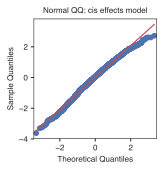

In [43]:
res = mod.resid

fig, ax = plt.subplots(figsize=(2.2, 2.2), ncols=1, nrows=1)
sm.qqplot(res, line='s', ax=ax)
ax.set_title("Normal QQ: cis effects model")
fig.savefig("avg_activ_qq.pdf", dpi="figure", bbox_inches="tight")

In [44]:
reduced_llf = mod.llf
reduced_llf

-3361.8527768147437

In [45]:
reduced_rsq = mod.rsquared
reduced_rsq

0.027416247514254088

## 6. add motifs to model

In [46]:
len(data_filt)

2307

In [47]:
data_filt["hg19_index"] = data_filt["hg19_id"] + "__" + data_filt["tss_tile_num"]
data_filt["mm9_index"] = data_filt["mm9_id"] + "__" + data_filt["tss_tile_num"]

In [48]:
human_df["hg19_index"] = human_df["hg19_id"] + "__" + human_df["tss_tile_num"]
mouse_df["mm9_index"] = mouse_df["mm9_id"] + "__" + mouse_df["tss_tile_num"]

In [49]:
def motif_disrupted(row):
    if row["motif_sum"] == 1:
        return "c - disrupted"
    elif row["motif_sum"] == 0:
        return "b - not present"
    else:
        return "a - maintained"

In [50]:
motif_results = {}

for i, motif_id in enumerate(uniq_motifs):
    tmp = data_filt.copy()
    
    # determine whether motif is in human or mouse sequence
    human_motifs_sub = human_df[human_df["#pattern name"] == motif_id]["hg19_index"].unique()
    mouse_motifs_sub = mouse_df[mouse_df["#pattern name"] == motif_id]["mm9_index"].unique()
    tmp["hg19_motif"] = tmp["hg19_index"].isin(human_motifs_sub)
    tmp["mm9_motif"] = tmp["mm9_index"].isin(mouse_motifs_sub)
    
    tmp["motif_sum"] = tmp[["hg19_motif", "mm9_motif"]].sum(axis=1)
    #tmp = tmp[tmp["motif_sum"] >= 1]
    tmp["motif_disrupted"] = tmp.apply(motif_disrupted, axis=1)
    n_maintained = len(tmp[tmp["motif_disrupted"] == "a - maintained"])
    
    # make reduced model
    mod = smf.ols(formula='box_abs_logFC_cis ~ mean_gc + mean_cpg + abs_delta_gc + abs_delta_cpg', 
                  data=tmp).fit()
    reduced_llf = mod.llf
    reduced_rsq = mod.rsquared
    
    # make full model
    full_mod = smf.ols(formula='box_abs_logFC_cis ~ mean_gc + mean_cpg + abs_delta_gc + abs_delta_cpg + motif_disrupted', 
                       data=tmp).fit()
    full_llf = full_mod.llf
    full_rsq = full_mod.rsquared
    
    # perform likelihood ratio test
    lr, p = lrtest(reduced_llf, full_llf)
    
    # calculate additional variance explained
    rsq = full_rsq - reduced_rsq
    
    # record beta
    beta = list(full_mod.params)[2]
    
    # beta p
    beta_p = list(full_mod.pvalues)[2]
    
    print("(#%s) %s: n w/ motif: %s ... p: %s, rsquared: %s" % (i+1, motif_id, len(tmp), p, rsq))
    motif_results[motif_id] = {"lr_test": lr, "pval": p, "rsq": rsq, "beta": beta, "beta_p": beta_p,
                               "n_maintained": n_maintained}

(#1) ZNF785: n w/ motif: 2307 ... p: 0.430206416394, rsquared: 0.000262299232774
(#2) ZNF235: n w/ motif: 2307 ... p: 0.00879903128575, rsquared: 0.00288907178689
(#3) ZNF432: n w/ motif: 2307 ... p: 0.0376024710193, rsquared: 0.00182074533256
(#4) ZNF93: n w/ motif: 2307 ... p: 0.11402998822, rsquared: 0.00105230858301
(#5) ZNF487: n w/ motif: 2307 ... p: 0.0358899059233, rsquared: 0.00185416129395
(#6) M10350_1: n w/ motif: 2307 ... p: 0.354534159562, rsquared: 0.000361294666725
(#7) ZNF304: n w/ motif: 2307 ... p: 0.151592109121, rsquared: 0.000866447140238
(#8) ZNF880: n w/ motif: 2307 ... p: 0.154198710339, rsquared: 0.000855520734731
(#9) M08865_1: n w/ motif: 2307 ... p: 0.202755472109, rsquared: 0.000683736064337
(#10) ZNF180: n w/ motif: 2307 ... p: 0.170530007168, rsquared: 0.000791521065729
(#11) ZNF311: n w/ motif: 2307 ... p: 0.372762663677, rsquared: 0.000334859483011
(#12) ZNF780A: n w/ motif: 2307 ... p: 0.0659588881967, rsquared: 0.00142424394562
(#13) M08863_1: n w/ m

(#101) M08876_1: n w/ motif: 2307 ... p: 0.353752862192, rsquared: 0.000362469404717
(#102) M08874_1: n w/ motif: 2307 ... p: 0.109480442537, rsquared: 0.00107936283222
(#103) ZNF417: n w/ motif: 2307 ... p: 0.001917757839, rsquared: 0.00404993513684
(#104) M05568_1: n w/ motif: 2307 ... p: 0.00352378051538, rsquared: 0.00358281303753
(#105) M06672_1: n w/ motif: 2307 ... p: 6.55038890871e-06, rsquared: 0.00852897938932
(#106) M08827_1: n w/ motif: 2307 ... p: 0.324167358921, rsquared: 0.000409713501411
(#107) ZNF528: n w/ motif: 2307 ... p: 0.000228784456769, rsquared: 0.00570762546697
(#108) M10405_1: n w/ motif: 2307 ... p: 0.095522650436, rsquared: 0.00117075894454
(#109) M06854_1: n w/ motif: 2307 ... p: 0.00755593130814, rsquared: 0.00300366490924
(#110) M09349_1: n w/ motif: 2307 ... p: 0.28357475974, rsquared: 0.000484643984441
(#111) M06186_1: n w/ motif: 2307 ... p: 0.0504990478464, rsquared: 0.00161112566062
(#112) M06131_1: n w/ motif: 2307 ... p: 0.158323331358, rsquared: 

(#199) M10316_1: n w/ motif: 2307 ... p: 0.0149690672794, rsquared: 0.00249259491746
(#200) M10001_1: n w/ motif: 2307 ... p: 0.903525437631, rsquared: 6.19367331423e-06
(#201) M03012_1: n w/ motif: 2307 ... p: 0.0189774369594, rsquared: 0.002317436476
(#202) M08731_1: n w/ motif: 2307 ... p: 0.253052180347, rsquared: 0.00055058458374
(#203) M05766_1: n w/ motif: 2307 ... p: 0.314675911574, rsquared: 0.000426101381866
(#204) ZNF587: n w/ motif: 2307 ... p: 0.502540830859, rsquared: 0.000189509575883
(#205) M06241_1: n w/ motif: 2307 ... p: 0.633431222433, rsquared: 9.58777974284e-05
(#206) M10440_1: n w/ motif: 2307 ... p: 0.0660654302759, rsquared: 0.0014231241747
(#207) M05982_1: n w/ motif: 2307 ... p: 0.00150039072684, rsquared: 0.00423946788911
(#208) M09267_1: n w/ motif: 2307 ... p: 0.741713735798, rsquared: 4.57934588408e-05
(#209) M09265_1: n w/ motif: 2307 ... p: 0.770841772471, rsquared: 3.57663698547e-05
(#210) M09241_1: n w/ motif: 2307 ... p: 0.778910290931, rsquared: 3.3

(#297) M09828_1: n w/ motif: 2307 ... p: 0.342678551488, rsquared: 0.00037950965314
(#298) M06027_1: n w/ motif: 2307 ... p: 0.138564806569, rsquared: 0.000924432031417
(#299) M09333_1: n w/ motif: 2307 ... p: 0.552037484732, rsquared: 0.000149092667087
(#300) M09011_1: n w/ motif: 2307 ... p: 0.00635949803474, rsquared: 0.00313381319868
(#301) M09445_1: n w/ motif: 2307 ... p: 0.00420017682505, rsquared: 0.00344879119096
(#302) M09363_1: n w/ motif: 2307 ... p: 0.472650587557, rsquared: 0.000217414791465
(#303) M06175_1: n w/ motif: 2307 ... p: 0.0157329229015, rsquared: 0.00245574832584
(#304) M00255_1: n w/ motif: 2307 ... p: 0.0207561960483, rsquared: 0.00225163716878
(#305) M09341_1: n w/ motif: 2307 ... p: 0.209357091138, rsquared: 0.000664126071144
(#306) M08769_1: n w/ motif: 2307 ... p: 0.160617742344, rsquared: 0.00082948324672
(#307) M08470_1: n w/ motif: 2307 ... p: 0.533118128078, rsquared: 0.000163746462787
(#308) M08469_1: n w/ motif: 2307 ... p: 0.529095909599, rsquared

(#395) M10360_1: n w/ motif: 2307 ... p: 0.206250001303, rsquared: 0.000673263329866
(#396) M09039_1: n w/ motif: 2307 ... p: 0.0238715479189, rsquared: 0.00214933809308
(#397) M09990_1: n w/ motif: 2307 ... p: 0.0986183798295, rsquared: 0.00114928202236
(#398) M09119_1: n w/ motif: 2307 ... p: 0.17397503504, rsquared: 0.000778915670418
(#399) M08749_1: n w/ motif: 2307 ... p: 0.098434391437, rsquared: 0.00115053780029
(#400) M10356_1: n w/ motif: 2307 ... p: 0.000144141125514, rsquared: 0.00607162699496
(#401) M09817_1: n w/ motif: 2307 ... p: 0.154308370187, rsquared: 0.000855065655875
(#402) M09415_1: n w/ motif: 2307 ... p: 0.0941367417973, rsquared: 0.00118062065693
(#403) M08947_1: n w/ motif: 2307 ... p: 0.239549532822, rsquared: 0.000582971975009
(#404) ZNF343: n w/ motif: 2307 ... p: 0.162825956568, rsquared: 0.000820798697424
(#405) ZNF641: n w/ motif: 2307 ... p: 0.271214322655, rsquared: 0.000510228056689
(#406) M10345_1: n w/ motif: 2307 ... p: 0.0237885927376, rsquared: 0

In [51]:
motif_results = pd.DataFrame.from_dict(motif_results, orient="index").reset_index()
motif_results = motif_results[motif_results["n_maintained"] >= 10]
print(len(motif_results))
motif_results.head()

366


,index,lr_test,pval,rsq,beta,beta_p,n_maintained
0,HKR1,4.621213,0.031579,0.001946,0.109090,0.064958,561
3,M00226_1,0.353341,0.552228,0.000149,0.074220,0.745966,27
5,M00255_1,5.347148,0.020756,0.002252,0.374279,0.021898,59
7,M00267_1,0.338088,0.560935,0.000143,0.112774,0.581039,35
8,M00402_1,1.631684,0.201470,0.000688,0.000359,0.998536,38


In [52]:
motif_results["padj"] = multicomp.multipletests(motif_results["pval"], method="fdr_bh")[1]
len(motif_results[motif_results["padj"] < 0.05])

104

In [53]:
motif_results["beta_padj"] = multicomp.multipletests(motif_results["beta_p"], method="fdr_bh")[1]
len(motif_results[motif_results["beta_padj"] < 0.05])

42

In [54]:
motif_results.sort_values(by="beta_padj").head(10)

,index,lr_test,pval,rsq,beta,beta_p,n_maintained,padj,beta_padj
20,M00977_1,17.059017,0.000036,0.007165,0.373655,0.000113,203,0.001877,0.010330
58,M05654_1,16.599899,0.000046,0.006973,0.397355,0.000089,169,0.001877,0.010330
65,M05695_1,18.263458,0.000019,0.007669,0.397857,0.000097,187,0.001408,0.010330
67,M05699_1,17.854226,0.000024,0.007498,0.406869,0.000053,191,0.001455,0.010330
34,M03040_1,18.904581,0.000014,0.007937,0.365632,0.000267,205,0.001257,0.010657
185,M08474_1,20.173021,0.000007,0.008467,0.716222,0.000208,34,0.000863,0.010657
186,M08476_1,16.627908,0.000045,0.006985,0.691486,0.000376,34,0.001877,0.010657
432,ZNF528,13.578554,0.000229,0.005708,0.650822,0.000285,37,0.004926,0.010657
208,M08653_1,16.068247,0.000061,0.006751,0.362603,0.000201,198,0.002236,0.010657
212,M08663_1,12.687335,0.000368,0.005334,0.617786,0.000379,55,0.006660,0.010657


## 7. join w/ TF info

In [55]:
motif_results_mrg = motif_results.merge(sig_motifs, on="index", suffixes=("_cis", "_activ"))
motif_results_mrg.sort_values(by="padj_cis").head()

,index,lr_test_cis,pval_cis,rsq_cis,beta_cis,beta_p,n_maintained,padj_cis,beta_padj,lr_test_activ,...,rsq_activ,beta_activ,padj_activ,short_id,HGNC symbol,activ_or_repr,no_CAGE_enr,eRNA_enr,lncRNA_enr,mRNA_enr
145,M08474_1,20.173021,0.000007,0.008467,0.716222,0.000208,34,0.000863,0.010657,15.141571,...,0.000926,-0.131019,5.328768e-04,M08474_1,ASCL4,repressing,NaN,1.0,NaN,NaN
146,M08474_1,20.173021,0.000007,0.008467,0.716222,0.000208,34,0.000863,0.010657,15.141571,...,0.000926,-0.131019,5.328768e-04,M08474_1,ASCL5,repressing,NaN,1.0,NaN,NaN
144,M08474_1,20.173021,0.000007,0.008467,0.716222,0.000208,34,0.000863,0.010657,15.141571,...,0.000926,-0.131019,5.328768e-04,M08474_1,ASCL1,repressing,NaN,1.0,NaN,NaN
119,M06672_1,20.320243,0.000007,0.008529,0.324241,0.000741,244,0.000863,0.017562,632.568434,...,0.037824,0.753912,1.041165e-137,M06672_1,NFYA,activating,NaN,NaN,2.0,3.0
120,M06673_1,21.027804,0.000005,0.008825,0.316779,0.000895,248,0.000863,0.018906,619.411706,...,0.037054,0.735249,7.170266e-135,M06673_1,NFYB,activating,NaN,NaN,2.0,3.0


In [56]:
#sig_results = motif_results_mrg[(motif_results_mrg["padj_cis"] < 0.05) & (motif_results_mrg["beta_cis"] > 0)]
sig_results = motif_results_mrg[(motif_results_mrg["beta_padj"] < 0.05) & (motif_results_mrg["beta_cis"] > 0)]
sig_results = sig_results.sort_values(by="beta_cis", ascending=False)

In [57]:
pal = {"repressing": sns.color_palette("pastel")[3], "activating": sns.color_palette("pastel")[0]}

In [58]:
full_pal = {}
for i, row in sig_results.iterrows():
    full_pal[row["HGNC symbol"]] = pal[row["activ_or_repr"]]

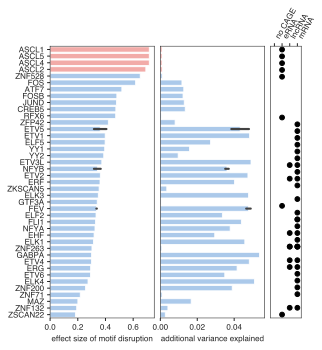

In [59]:
fig = plt.figure(figsize=(4.5, 5))

ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=3)
ax2 = plt.subplot2grid((1, 7), (0, 3), colspan=3)
ax3 = plt.subplot2grid((1, 7), (0, 6), colspan=1)

yvals = []
symbs = []
c = 0
for i, row in sig_results.iterrows():
    symb = row["HGNC symbol"]
    if symb not in symbs:
        yvals.append(c)
        symbs.append(symb)
        c += 1
    else:
        yvals.append(c)

sig_results["yval"] = yvals
sns.barplot(y="HGNC symbol", x="beta_cis", data=sig_results, palette=full_pal, ax=ax1)
ax1.set_ylabel("")
ax1.set_xlabel("effect size of motif disruption")

sns.barplot(y="HGNC symbol", x="rsq_activ", data=sig_results, palette=full_pal, ax=ax2)
ax2.set_ylabel("")
ax2.tick_params(left=False, labelleft=False)
ax2.set_xlabel("additional variance explained")

melt = pd.melt(sig_results, id_vars=["HGNC symbol", "yval"], value_vars=["no_CAGE_enr", "eRNA_enr",
                                                                                 "lncRNA_enr", "mRNA_enr"])
ax3.plot(melt["value"], melt["yval"], 'o', color="black")
ax3.set_xlim((-0.5, 3.5))
ax3.set_ylim((np.max(yvals)-0.5, -0.5))
ax3.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False, top=True, labeltop=True)
ax3.xaxis.set_ticks([0, 1, 2, 3])
ax3.set_xticklabels(["no CAGE", "eRNA", "lncRNA", "mRNA"], rotation=60, ha="left", va="bottom")

plt.show()
fig.savefig("cis_motif_enrichment.pdf", dpi="figure", bbox_inches="tight")
plt.close()

In [60]:
data_filt = data_elem[((data_elem["HUES64_padj_hg19"] < QUANT_ALPHA) | (data_elem["mESC_padj_mm9"] < QUANT_ALPHA))]
print(len(data_filt))
# data_filt = data_filt[data_filt["tss_tile_num"] == "tile1"].drop("orig_species", axis=1).drop_duplicates()
# len(data_filt)

2307


In [61]:
data_filt["hg19_index"] = data_filt["hg19_id"] + "__" + data_filt["tss_tile_num"]
data_filt["mm9_index"] = data_filt["mm9_id"] + "__" + data_filt["tss_tile_num"]

In [62]:
def uniq_motif(row):
    if row.hg19_motif == True:
        if row.mm9_motif == True:
            return "maintained"
        else:
            return "disrupted in mouse"
    else:
        if row.mm9_motif == True:
            return "disrupted in human"
        else:
            return "not present"

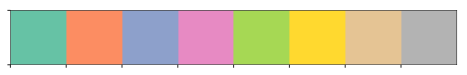

In [63]:
sns.palplot(sns.color_palette("Set2"))

0.940340378162
0.821669558116


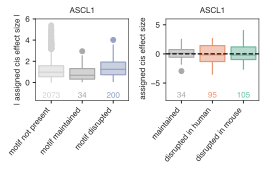

0.940340378162
0.821669558116


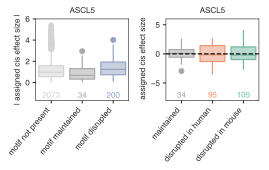

0.975025041008
0.226731987296


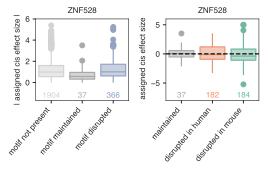

0.00777974007053
0.0608190227691


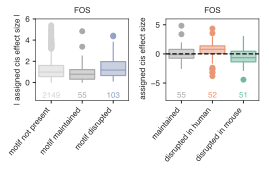

1.51723510555e-07
4.19916359636e-05


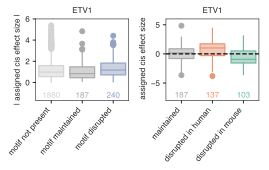

1.25121769732e-06
1.7192792804e-07


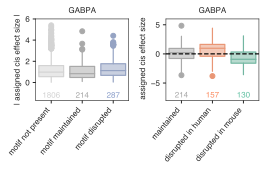

In [65]:
# plot some examples
examps = ["ASCL1", "ASCL5", "ZNF528", "FOS", "ETV1", "GABPA"]
order1 = ["b - not present", "a - maintained", "c - disrupted"]
order2 = ["maintained", "disrupted in human", "disrupted in mouse"]
pal1 = {"b - not present": "lightgray", "a - maintained": "darkgray", "c - disrupted": sns.color_palette("Set2")[2]}
pal2 = {"maintained": "darkgray", "disrupted in human": sns.color_palette("Set2")[1], 
        "disrupted in mouse": sns.color_palette("Set2")[0]}

for symb in examps:
    motif_id = sig_results[sig_results["HGNC symbol"] == symb]["index"].iloc[0]
    
    tmp = data_filt.copy()
    
    # determine whether motif is in human or mouse sequence
    human_motifs_sub = human_df[human_df["#pattern name"] == motif_id]["hg19_index"].unique()
    mouse_motifs_sub = mouse_df[mouse_df["#pattern name"] == motif_id]["mm9_index"].unique()
    tmp["hg19_motif"] = tmp["hg19_index"].isin(human_motifs_sub)
    tmp["mm9_motif"] = tmp["mm9_index"].isin(mouse_motifs_sub)
    
    tmp["motif_sum"] = tmp[["hg19_motif", "mm9_motif"]].sum(axis=1)
    #tmp = tmp[tmp["motif_sum"] >= 1]
    tmp["motif_disrupted"] = tmp.apply(motif_disrupted, axis=1)
    tmp["uniq_motif"] = tmp.apply(uniq_motif, axis=1)
    
    fig, axarr = plt.subplots(figsize=(4, 1.5), nrows=1, ncols=2)
    
    ax = axarr[0]
    sns.boxplot(data=tmp, x="motif_disrupted", y="abs_logFC_cis", order=order1, palette=pal1, 
                flierprops = dict(marker='o', markersize=5), ax=ax)
    mimic_r_boxplot(ax)
    ax.set_xticklabels(["motif not present", "motif maintained", "motif disrupted"], rotation=50, 
                       ha="right", va="top")
    ax.set_ylabel("| assigned cis effect size |")
    ax.set_title(symb)
    ax.set_xlabel("")
    
    for i, label in enumerate(order1):
        n = len(tmp[tmp["motif_disrupted"] == label])
        ax.annotate(str(n), xy=(i, -0.9), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='top', 
                    color=pal1[label], size=fontsize)

    ax.set_ylim((-1.7, 6))

    ax = axarr[1]
    sns.boxplot(data=tmp, x="uniq_motif", y="logFC_cis_one", order=order2, palette=pal2,
                flierprops = dict(marker='o', markersize=5), ax=ax)
    ax.set_xticklabels(order2, rotation=50, ha="right", va="top")
    mimic_r_boxplot(ax)
    ax.set_ylabel(" assigned cis effect size")
    ax.set_title(symb)
    ax.set_xlabel("")
    ax.axhline(y=0, linestyle="dashed", color="black", zorder=100)
    
    for i, label in enumerate(order2):
        n = len(tmp[tmp["uniq_motif"] == label])
        ax.annotate(str(n), xy=(i, -6.5), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='top', 
                    color=pal2[label], size=fontsize)
        
    # calc p-vals b/w dists
    dist1 = np.asarray(tmp[tmp["uniq_motif"] == "maintained"]["logFC_cis_one"])
    dist2 = np.asarray(tmp[tmp["uniq_motif"] == "disrupted in human"]["logFC_cis_one"])
    dist3 = np.asarray(tmp[tmp["uniq_motif"] == "disrupted in mouse"]["logFC_cis_one"])

    dist1 = dist1[~np.isnan(dist1)]
    dist2 = dist2[~np.isnan(dist2)]
    dist3 = dist3[~np.isnan(dist3)]

    u, pval1 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
    u, pval2 = stats.mannwhitneyu(dist1, dist3, alternative="two-sided", use_continuity=False)
    print(pval1)
    print(pval2)

#     annotate_pval(ax, 0.2, 0.8, 3, 0, 3, pval1, fontsize)
#     annotate_pval(ax, 0.2, 1.8, 4, 0, 4, pval2, fontsize)

    ax.set_ylim((-8, 6))
    
    plt.subplots_adjust(wspace=0.4)
    plt.show()

## 8. for every sequence pair, calculate the # identical motifs, the # motifs that fully turn over, and the # motifs that partially turn over

defined as:
- identical motifs = identical sequence in both species
- full turnover = motifs that are only present in one species
- partial turnover = motifs that are in both species but don't map to the exact same sequence

In [66]:
print(len(data))
data.head()

5482


,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.333118,-0.035380,0.988785,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.536610,-0.387857,0.921562,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.260673,-0.192854,0.959265,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.439975,-0.723633,0.197618,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.267503,-0.511763,0.453490,no cis/trans int. effect,no cis/trans int. effect


In [67]:
turnover_results = {}

for i, row in data.iterrows():
    if i % 100 == 0:
        print("...# %s..." % (i+1))

    human_id = row["hg19_id"]
    mouse_id = row["mm9_id"]
    tile_num = row["tss_tile_num"]
    
    human_motifs_sub = human_df[(human_df["hg19_id"] == human_id) & (human_df["tss_tile_num"] == tile_num)]
    mouse_motifs_sub = mouse_df[(mouse_df["mm9_id"] == mouse_id) & (mouse_df["tss_tile_num"] == tile_num)]
    
    # find total number of unique motifs (in both species)
    human_motif_ids = list(human_motifs_sub["#pattern name"].unique())
    mouse_motif_ids = list(mouse_motifs_sub["#pattern name"].unique())
    total_uniq_motifs = len(set(human_motif_ids + mouse_motif_ids))
    
    # find difference in motifs b/w the two species
    delta_motifs = len(mouse_motif_ids) - len(human_motif_ids)
    
    # find number of motifs that are in both species
    merge_sub = human_motifs_sub[["#pattern name", 
                                  "matched sequence"]].merge(mouse_motifs_sub[["#pattern name", 
                                                                               "matched sequence"]],
                                                             on="#pattern name",
                                                             suffixes=(" human", " mouse"))
    merge_sub = merge_sub.drop_duplicates()
    
    # find number of motifs that are *exactly the same* in both species
    merge_sub["identical"] = merge_sub["matched sequence human"] == merge_sub["matched sequence mouse"]
    
    # since there can be more than one occurrence of the same motif: 
    # if there is at least 1 instance of an identical motif, call it identical
    # otherwise, call it partial
    # to do this, sort the df and keep the first occurrence (which will always = True if it's there)
    merge_sub = merge_sub.sort_values(by=["#pattern name", 
                                          "identical"], ascending=False)[["#pattern name", "identical"]]
    merge_sub = merge_sub.drop_duplicates(subset="#pattern name")
    total_in_both = len(merge_sub)
    
    n_identical = len(merge_sub[merge_sub["identical"]])
    
    # find number that are partially different
    n_partial = len(merge_sub[~merge_sub["identical"]])
    
    # find number of motifs that fully turn over between species (i.e. are in only one species)
    n_human_uniq = len(set(human_motif_ids).difference(set(mouse_motif_ids)))
    n_mouse_uniq = len(set(mouse_motif_ids).difference(set(human_motif_ids)))
    n_turnover = n_human_uniq + n_mouse_uniq
    
    turnover_results["%s__%s__%s" % (human_id, mouse_id, tile_num)] = {"total_motifs": total_uniq_motifs,
                                                                       "total_shared_motifs": total_in_both,
                                                                       "n_identical_motifs": n_identical,
                                                                       "n_partial_motifs": n_partial,
                                                                       "n_turnover_motifs": n_turnover,
                                                                       "delta_motifs": delta_motifs}

...# 1...
...# 101...
...# 201...
...# 301...
...# 401...
...# 501...
...# 601...
...# 701...
...# 801...
...# 901...
...# 1001...
...# 1101...
...# 1201...
...# 1301...
...# 1401...
...# 1501...
...# 1601...
...# 1701...
...# 1801...
...# 1901...
...# 2001...
...# 2101...
...# 2201...
...# 2301...
...# 2401...
...# 2501...
...# 2601...
...# 2701...
...# 2801...
...# 2901...
...# 3001...
...# 3101...
...# 3201...
...# 3301...
...# 3401...
...# 3501...
...# 3601...
...# 3701...
...# 3801...
...# 3901...
...# 4001...
...# 4101...
...# 4201...
...# 4301...
...# 4401...
...# 4501...
...# 4601...
...# 4701...
...# 4801...
...# 4901...
...# 5001...
...# 5101...
...# 5201...
...# 5301...
...# 5401...


In [68]:
turnover_df = pd.DataFrame.from_dict(turnover_results, orient="index").reset_index()

# split index column to separate id columns
turnover_df["hg19_id"] = turnover_df["index"].str.split("__", expand=True)[0]
turnover_df["mm9_id"] = turnover_df["index"].str.split("__", expand=True)[1]
turnover_df["tss_tile_num"] = turnover_df["index"].str.split("__", expand=True)[2]

# calculate percentages
turnover_df["perc_shared_motifs"] = (turnover_df["total_shared_motifs"]/turnover_df["total_motifs"])*100
turnover_df["perc_identical_motifs"] = (turnover_df["n_identical_motifs"]/turnover_df["total_shared_motifs"])*100
turnover_df["perc_partial_motifs"] = (turnover_df["n_partial_motifs"]/turnover_df["total_shared_motifs"])*100
turnover_df["perc_turnover_motifs"] = (turnover_df["n_turnover_motifs"]/turnover_df["total_motifs"])*100
turnover_df["abs_delta_motifs"] = np.abs(turnover_df["delta_motifs"])

turnover_df.head()

,index,total_motifs,total_shared_motifs,n_identical_motifs,n_partial_motifs,n_turnover_motifs,delta_motifs,hg19_id,mm9_id,tss_tile_num,perc_shared_motifs,perc_identical_motifs,perc_partial_motifs,perc_turnover_motifs,abs_delta_motifs
0,h.1000__m.883__tile1,136,56,1,55,80,42,h.1000,m.883,tile1,41.176471,1.785714,98.214286,58.823529,42
1,h.1000__m.883__tile2,53,10,0,10,43,1,h.1000,m.883,tile2,18.867925,0.000000,100.000000,81.132075,1
2,h.1001__m.884__tile2,131,77,26,51,54,-20,h.1001,m.884,tile2,58.778626,33.766234,66.233766,41.221374,20
3,h.1002__m.885__tile1,77,49,25,24,28,-18,h.1002,m.885,tile1,63.636364,51.020408,48.979592,36.363636,18
4,h.1002__m.885__tile2,79,43,15,28,36,-24,h.1002,m.885,tile2,54.430380,34.883721,65.116279,45.569620,24


## 9. merge motif turnover data w/ cis effects

In [69]:
data_motifs = data.merge(turnover_df, on=["hg19_id", "mm9_id", "tss_tile_num"], how="left")
print(len(data_motifs))
data_motifs.head()

5482


,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,total_shared_motifs,n_identical_motifs,n_partial_motifs,n_turnover_motifs,delta_motifs,perc_shared_motifs,perc_identical_motifs,perc_partial_motifs,perc_turnover_motifs,abs_delta_motifs
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,42,21,21,34,-16,55.263158,50.000000,50.000000,44.736842,16
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,23,2,21,92,48,20.000000,8.695652,91.304348,80.000000,48
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,51,5,46,35,1,59.302326,9.803922,90.196078,40.697674,1
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,62,38,24,45,27,57.943925,61.290323,38.709677,42.056075,27
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,48,35,13,57,43,45.714286,72.916667,27.083333,54.285714,43


## 6. filter data

In [70]:
data_filt = data_motifs[((data_motifs["HUES64_padj_hg19"] < QUANT_ALPHA) | (data_motifs["mESC_padj_mm9"] < QUANT_ALPHA))]
len(data_filt)

2307

In [71]:
data_filt_sp = data_filt.drop("orig_species", axis=1)
data_filt_sp.drop_duplicates(inplace=True)
len(data_filt_sp)

2294

In [72]:
data_filt_tile1 = data_filt[data_filt["tss_tile_num"] == "tile1"]
len(data_filt_tile1)

1409

In [73]:
data_filt_tile1_sp = data_filt_sp[data_filt_sp["tss_tile_num"] == "tile1"]
len(data_filt_tile1_sp)

1399

In [74]:
data_filt_tile2 = data_filt[data_filt["tss_tile_num"] == "tile2"]
len(data_filt_tile2)

898

In [75]:
data_filt_tile2_sp = data_filt_sp[data_filt_sp["tss_tile_num"] == "tile2"]
len(data_filt_tile2_sp)

895

## 7. plot cis effects v motif turnover

In [76]:
dfs = [data_filt_sp, data_filt_tile1_sp, data_filt_tile2_sp]
titles = ["both tiles", "tile1 only", "tile2 only"]
labels = ["both_tiles", "tile1_only", "tile2_only"]

In [77]:
order = ["no cis effect", "significant cis effect"]
palette = {"no cis effect": "gray", "significant cis effect": sns.color_palette("Set2")[2]}

### % shared motifs

1.53254102935e-17


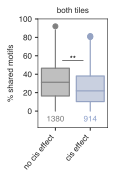

5.89878012603e-12


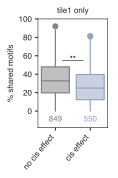

3.37665502958e-07


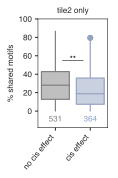

In [78]:
for df, title, label in zip(dfs, titles, labels):
    
    fig = plt.figure(figsize=(1.25, 2))
    ax = sns.boxplot(data=df, x="cis_status_one", y="perc_shared_motifs", palette=palette, order=order,
                     flierprops = dict(marker='o', markersize=5))
    mimic_r_boxplot(ax)
    
    ax.set_xticklabels(["no cis effect", 'cis effect'], rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("% shared motifs")
    ax.set_title(title)
    
    for i, l in enumerate(order):
        n = len(df[df["cis_status_one"] == l])
        ax.annotate(str(n), xy=(i, -5), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='top', 
                    color=palette[l], size=fontsize)

    ax.set_ylim((-18, 100))
    
    # calc p-vals b/w dists
    dist1 = np.asarray(df[df["cis_status_one"] == "no cis effect"]["perc_shared_motifs"])
    dist2 = np.asarray(df[df["cis_status_one"] != "no cis effect"]["perc_shared_motifs"])

    dist1 = dist1[~np.isnan(dist1)]
    dist2 = dist2[~np.isnan(dist2)]

    u, pval = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
    print(pval)

    annotate_pval(ax, 0.2, 0.8, 55, 0, 52, pval, fontsize)
    
    plt.show()
    fig.savefig("cis_effect_v_shared_motifs.%s.pdf" % label, dpi="figure", bbox_inches="tight")
    plt.close()

## 8. plot motif #s across biotypes

In [82]:
def turnover_status(row):
    if pd.isnull(row["biotype_switch_minimal"]):
        return np.nan
    else:
        if "CAGE turnover" in row["biotype_switch_minimal"]:
            return "CAGE turnover"
        else:
            return "none"
    
def turnover_biotype(row):
    if pd.isnull(row["biotype_switch_minimal"]):
        return np.nan
    else:
        if "CAGE turnover" in row["biotype_switch_minimal"]:
            return row["biotype_switch_minimal"].split(" - ")[1]
        else:
            return row["biotype_switch_minimal"]

In [83]:
turnover_order = ["eRNA", "lncRNA", "mRNA"]
turnover_pal = {"CAGE turnover": "gray", "none": sns.color_palette("Set2")[2]}
hue_order = ["CAGE turnover", "none"]

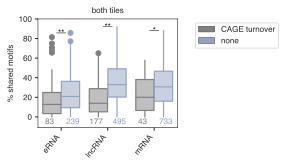

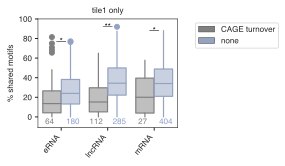

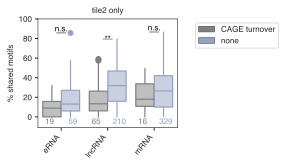

In [84]:
for df, title, label in zip(dfs, titles, labels):
    df["turnover_status"] = df.apply(turnover_status, axis=1)
    df["turnover_biotype"] = df.apply(turnover_biotype, axis=1)
    
    fig = plt.figure(figsize=(2.5, 2))
    ax = sns.boxplot(data=df, x="turnover_biotype", y="perc_shared_motifs", hue="turnover_status",
                     flierprops = dict(marker='o', markersize=5), 
                     order=turnover_order, hue_order=hue_order, palette=turnover_pal)
    mimic_r_boxplot(ax)

    ax.set_xticklabels(turnover_order, rotation=50, ha='right', va='top')
    ax.set_xlabel("")
    ax.set_ylabel("% shared motifs")
    ax.set_title(title)

    for i, l in enumerate(turnover_order):
        sub = df[df["turnover_biotype"] == l]
        dist1 = np.asarray(sub[sub["turnover_status"] == "CAGE turnover"]["perc_shared_motifs"])
        dist2 = np.asarray(sub[sub["turnover_status"] == "none"]["perc_shared_motifs"])
        
        dist1 = dist1[~np.isnan(dist1)]
        dist2 = dist2[~np.isnan(dist2)]
        
        u, pval = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
        ymax = np.max(dist2)
        
        if pval >= 0.05:
            annotate_pval(ax, i-0.1, i+0.1, ymax, 0, ymax, pval, fontsize)
        else:
            annotate_pval(ax, i-0.1, i+0.1, ymax, 0, ymax-4, pval, fontsize)
            
        ax.annotate(str(len(dist1)), xy=(i-0.25, -9), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color="gray", size=fontsize)
        ax.annotate(str(len(dist2)), xy=(i+0.25, -9), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=sns.color_palette("Set2")[2], size=fontsize)

    ax.set_ylim((-11, 100))
    plt.legend(loc=2, bbox_to_anchor=(1.1, 1))
    plt.show()
    fig.savefig("shared_motifs_biotypes.%s.pdf" % label, dpi="figure", bbox_inches="tight")
    plt.close()

## 11. write motif files

In [85]:
len(human_df)

457658

In [86]:
len(mouse_df)

429119

In [87]:
human_f = "../../../data/04__mapped_motifs/human_motifs_filtered.txt.gz"
human_df.to_csv(human_f, sep="\t", index=False, compression="gzip")

In [88]:
mouse_f = "../../../data/04__mapped_motifs/mouse_motifs_filtered.txt.gz"
mouse_df.to_csv(mouse_f, sep="\t", index=False, compression="gzip")